## Please provide your inputs as followed:

- **start_date**: The start date of your period of interest in the format **dd mm YYYY**
- **end_date**: The end date of your period of interestin the format **dd mm YYYY**
- **region**: The region of interest. Please provide this in a **bounding box format** (e.g. [10, -5, 25, 20]) or a **country name**
- **lower_limit** & **upper_limit**: These limits are used if you would like to filter the data to a certain range of concentration values

In [119]:
start_date = "2023 08 20"
end_date = "2023 08 25"
region = "Australia"


lower_limit = input("Enter the lower concentration limit (in ppm) or press enter for default: ")
if lower_limit == "":
        lower_limit = 1500
else:
    lower_limit = float(lower_limit)
    
    
upper_limit = input("Enter the upper concentration limit (in ppm) or press enter for default: ")
if upper_limit == "":
        upper_limit = 2000
else:
    upper_limit = float(upper_limit)

Enter the lower concentration limit (in ppm) or press enter for default:  1800
Enter the upper concentration limit (in ppm) or press enter for default:  1900


## Library imports 

In [95]:
%matplotlib inline
import xarray as xr
import fsspec
import numpy as np
import planetary_computer
import pystac_client
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, time
import json

## Starting up PySTAC client

In [96]:
# Initialize PySTAC client for data query
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

## User Input

### Processing of user input

In [97]:
# Function to convert date format 
def convert_format_date(input_date):
    correct_formats = ["%d %m %Y", "%Y %m %d", "%d/%m/%Y", "%Y/%m/%d", "%d-%m-%Y", "%Y-%m-%d"]
    
    for format_str in correct_formats:
        try:
            date_obj = datetime.strptime(input_date, format_str)
            formatted_date = date_obj.strftime("%Y-%m-%d")
            return formatted_date
        except ValueError: # Raised if input format is not compatible with set standard 
            pass
    
    raise ValueError("Invalid data format")

# Convert user start date format
try:
    start_date = convert_format_date(start_date)
except ValueError:
    print("Invalid start date format. Please check the acceptable formats")
            
# Convert user end date format
try:
    end_date = convert_format_date(end_date)
except ValueError:
    print("Invalid end date format. Please check the acceptable formats")

date_period = start_date + "/" + end_date 
print(date_period)

2023-08-20/2023-08-25


In [98]:
if start_date != end_date:
    date_range = np.arange(np.datetime64(start_date), np.datetime64(end_date))
    date_range = [np.datetime64(date, 'ns') for date in date_range]
else:
    date_range = [np.datetime64(start_date, 'ns')]

## Search for product

In [99]:
# Get geopandas in-built naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/tmp/ipykernel_386/755612632.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [100]:
if type(region) is str:
    ROI = world[world["name"] == region]
    ROI_bbox = ROI.total_bounds
else:
    ROI_bbox = region

In [101]:
def search_catalog(region, date_period):
    search_parameters = {
        "collections": "sentinel-5p-l2-netcdf",
        "datetime": date_period,
        "query": {"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
    }
   
    #bbox input
    if isinstance(region, list) and len(region) == 4:
        min_long, min_lat, max_long, max_lat = region
        #-180 to 180 for longitudes, -90 to 90 for latitudes
        long = all(-180 <= coordinates <= 180 for coordinates in [min_long, max_long]) 
        lat = all(-90 <= coordinates <= 90 for coordinates in [min_lat, max_lat])
        
        if long and lat:
            search_parameters["bbox"] = region
        elif not long:
            raise ValueError("Invalid longitudes in bbox")
        elif not lat:
            raise ValueError("Invalid latitudes in bbox")
        else:
            raise ValueError("Invalid coordinates in bbox")
        
    else:
        if ROI.empty: # Raise error if invalid region input
            raise ValueError("Invalid country name")
        
        gjson = json.loads(ROI.to_json())
        coordinates = gjson["features"][0]["geometry"]["coordinates"]
        
        if not isinstance(coordinates, list): 
            coordinates = [coordinates]    
                         
        #MultiPolygon is used to represent multiple polygons bbox and country     
        search_parameters["intersects"] = {
            "type": "MultiPolygon", 
            "coordinates": coordinates
        }
        
    search = catalog.search(**search_parameters)
    items = search.item_collection()

    return items

# Use search_catalog function with a single variable "region" for bbox and country name
result = search_catalog(region=region, date_period=date_period)

# Print the result
print(f"Number of items for input: {len(result)}")

Number of items for input: 17


In [102]:
result

id: S5P_L2_CH4____20230825T063323_20230825T081453_30388
"bbox: [-180.0, -88.80499, 180.0, 90.0]"
"s5p:ch4: {'input_band': ['L1B_RA_BD7', 'L1B_RA_BD8', 'L1B_RA_BD6', 'L2__CO____', 'L2__FRESCO', 'L2__NP_BD6', 'L2__NP_BD7'], 'irradiance_accompanied': ['L1B_IR_SIR', 'L1B_IR_UVN'], 'geolocation_grid_from_band': 7}"
datetime: 2023-08-25T07:21:06Z
platform: Sentinel 5 Precursor
"s5p:shape: [3735, 215]"
instruments: ['TROPOMI']
end_datetime: 2023-08-25T07:47:14Z
constellation: Sentinel-5P
start_datetime: 2023-08-25T06:54:58Z
s5p:product_name: ch4


## Process queried data into a dataset

In [103]:
item_links = [item.assets['ch4'].href for item in result]
item_links

f = fsspec.open_files(item_links)
f = [file.open() for file in f]

In [105]:
d = xr.open_mfdataset(f, group="PRODUCT", engine="h5netcdf", concat_dim="time", combine='nested', join="outer") 
d

<xarray.Dataset>
Dimensions:                              (scanline: 4173, ground_pixel: 215,
                                          corner: 4, layer: 12, level: 13,
                                          time: 17)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
  * time                                 (time) datetime64[ns] 2023-08-25 ......
    latitude                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    longitude                            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
Data variables:
    delta_time                           (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4173), meta=np.ndarray>
    time_utc                             (time, scanline) object dask.array<chunksize=(1, 4173), meta=np.ndarray>
    qa_value                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>

In [150]:
# Filter the data based on the limits given by the user
d_filtered = d.where((d.methane_mixing_ratio_bias_corrected >= lower_limit).compute() & (d.methane_mixing_ratio_bias_corrected <= upper_limit).compute(), drop=True)

# Group the data by time
d_grouped = d_filtered.groupby("time") 
d_grouped.groups

{numpy.datetime64('2023-08-20T00:00:00.000000000'): [14, 15, 16],
 numpy.datetime64('2023-08-21T00:00:00.000000000'): [11, 12, 13],
 numpy.datetime64('2023-08-22T00:00:00.000000000'): [8, 9, 10],
 numpy.datetime64('2023-08-23T00:00:00.000000000'): [5, 6, 7],
 numpy.datetime64('2023-08-24T00:00:00.000000000'): [3, 4],
 numpy.datetime64('2023-08-25T00:00:00.000000000'): [0, 1, 2]}

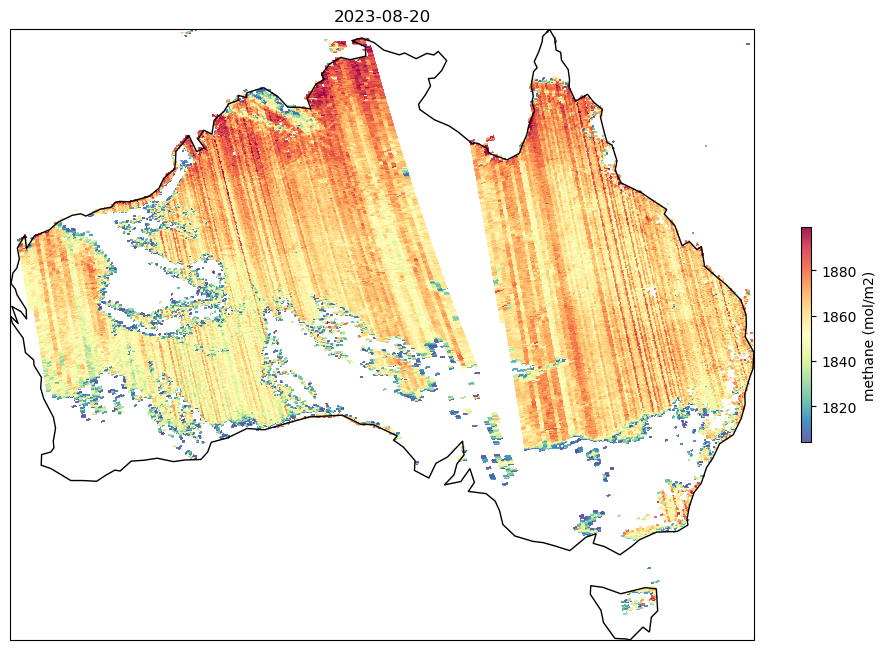

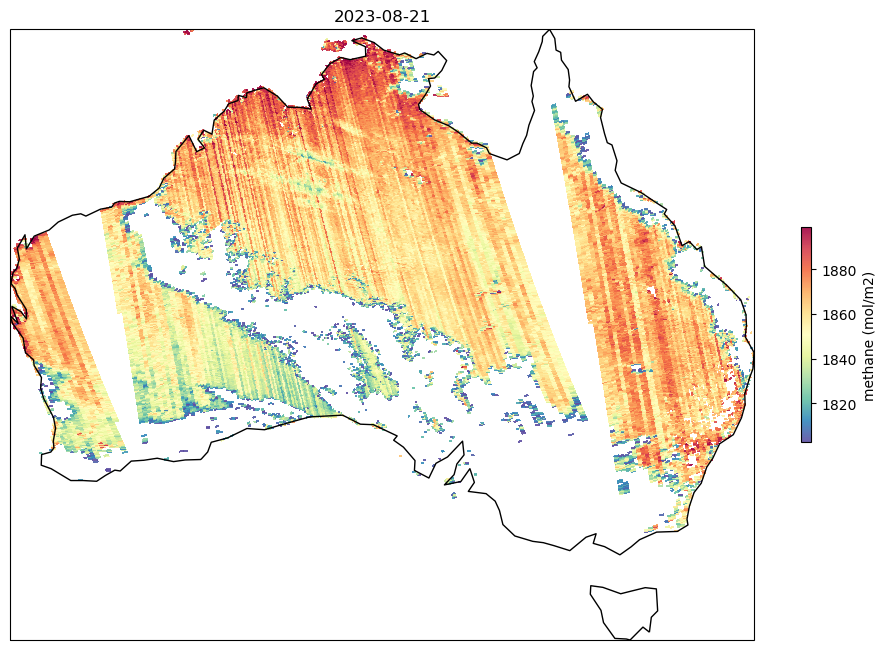

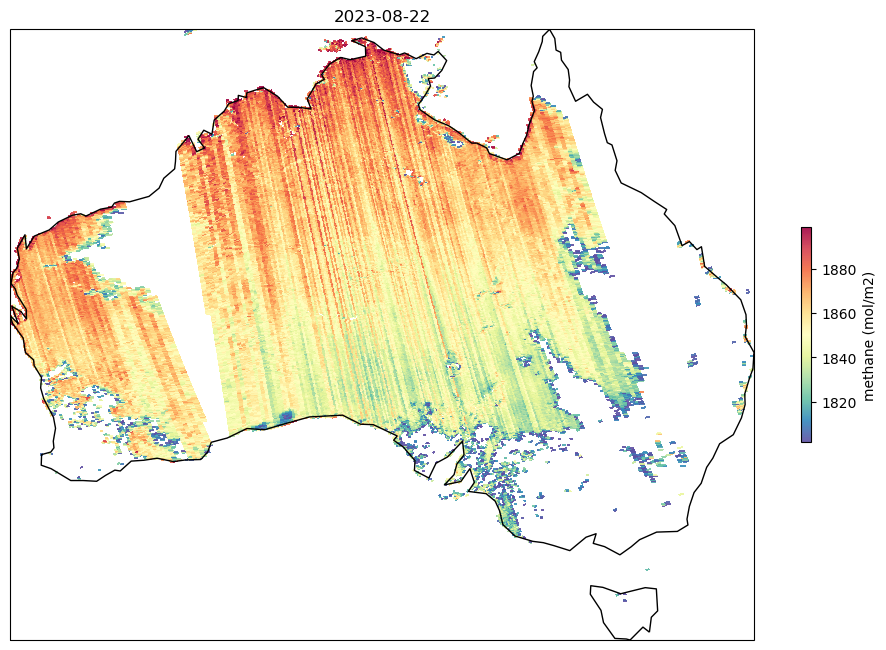

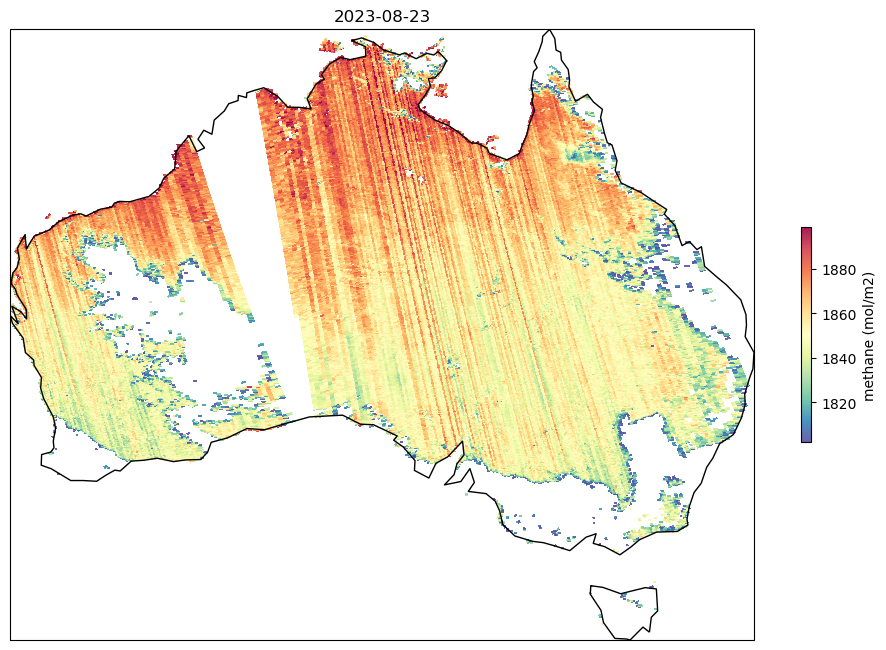

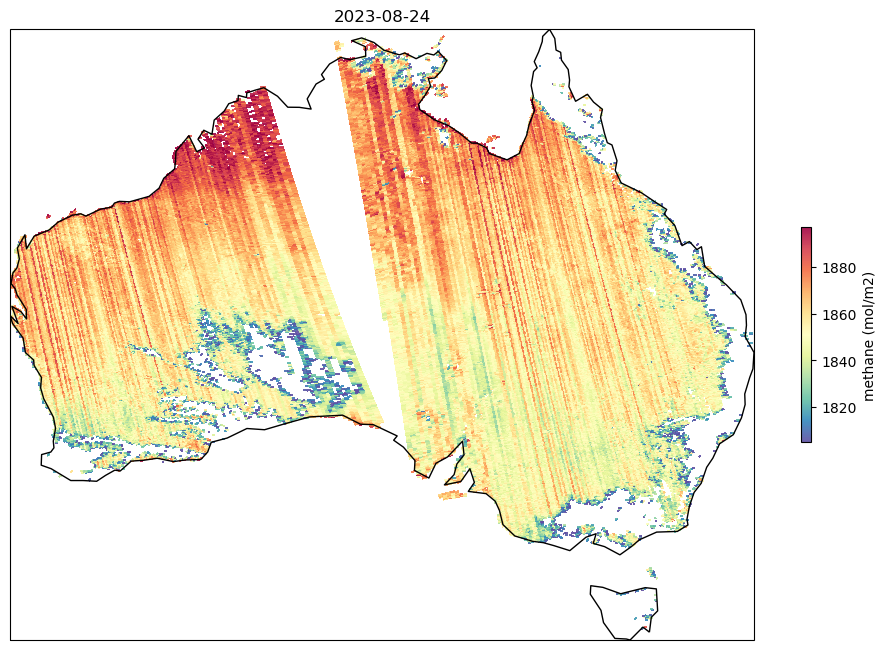

In [154]:
for date in date_range:
    # Initialize the map
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    continent_borders = world.dissolve(by='continent')
    continent_borders.boundary.plot(ax=ax, linewidth=1, color='black')
    
    # Set plot title
    date_title = pd.to_datetime(date).date()
    plt.title(str(date_title))
    
    # Set the map to show only ROI
    ax.set_xlim(ROI_bbox[0], ROI_bbox[2])
    ax.set_ylim(ROI_bbox[1], ROI_bbox[3])
    
    for time in d_grouped[date].methane_mixing_ratio_bias_corrected:
        # Extract the relevant data (assuming the variable name is 'methane_mixing_ratio_bias_corrected')
        data = time.values #print(data.values)
        lon = time.longitude.values
        lat = time.latitude.values

        # Calculate the minimum and maximum value of the dataset while ignoring NaN values
        vmin, vmax = np.nanpercentile(data, [1, 99])

        # Plot the data
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        colormesh = ax.pcolor(lon,
                              lat,
                              data,cmap="Spectral_r",
                              norm=norm,
                              transform=ccrs.PlateCarree(),
                              alpha=0.9,
                              rasterized=True)
        
        # Save the produced images as jpg
        # plt.savefig("output/concentration_map" + str(date) + ".jpg")
        
    fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="methane (mol/m2)")
    
plt.show()

## Plot Time Series (GIF Format)

In [ ]:
import glob
from PIL import Image

frames = [Image.open(image) for image in glob.glob(f"output/*.jpg")]
frame_one = frames[0]
frame_one.save("time_series.gif", format="GIF", append_images=frames,
           save_all=True, duration=1500, loop=0)